# Cryptocurrency Price Prediction with ARIMA, LSTM, and Prophet
This notebook demonstrates the implementation of three powerful time series forecasting models to predict cryptocurrency price movements.

## 1. Import Required Libraries
Import necessary libraries for data processing, visualization, and model implementation.

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Time series and statistical tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Try importing Deep learning libraries
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    tensorflow_available = True
except ImportError:
    tensorflow_available = False
    print("Warning: TensorFlow not available. Using sklearn alternatives for neural networks.")

# Try importing Prophet
try:
    from prophet import Prophet
    prophet_available = True
except ImportError:
    prophet_available = False
    print("Warning: Prophet not available. Install with: pip install prophet")

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("Libraries imported successfully!")
if not tensorflow_available:
    print("Note: LSTM cells will be adapted for sklearn")
if not prophet_available:
    print("Note: Prophet cells will be skipped")

Libraries imported successfully!
Note: LSTM cells will be adapted for sklearn


## 2. Load and Explore Time Series Data
Load historical price data and perform exploratory analysis.

In [97]:
# Load data
data_path = '../data/processed/processed_data.csv'
df = pd.read_csv(data_path)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (3650, 7)

First few rows:
                 date coin    open    high     low   close       volume
0 2025-01-23 05:30:00  ADA  0.9827  1.0118  0.9512  0.9867  192569354.5
1 2025-01-24 05:30:00  ADA  0.9867  1.0100  0.9636  0.9712  124426928.3
2 2025-01-25 05:30:00  ADA  0.9712  0.9919  0.9642  0.9766   56721656.8
3 2025-01-26 05:30:00  ADA  0.9766  1.0003  0.9515  0.9530   73197919.3
4 2025-01-27 05:30:00  ADA  0.9530  0.9587  0.8568  0.9345  257950415.8

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3650 non-null   datetime64[ns]
 1   coin    3650 non-null   object        
 2   open    3650 non-null   float64       
 3   high    3650 non-null   float64       
 4   low     3650 non-null   float64       
 5   close   3650 non-null   float64       
 6   volume  3650 non-null   float64       
dtypes: d

In [98]:
# Select a specific cryptocurrency (e.g., Bitcoin)
coin = 'BTC'
coin_data = df[df['coin'] == coin].copy().sort_values('date').reset_index(drop=True)

print(f"Total records for {coin}: {len(coin_data)}")
print(f"Date range: {coin_data['date'].min()} to {coin_data['date'].max()}")
print(f"\nPrice Statistics for {coin}:")
print(coin_data['close'].describe())

Total records for BTC: 365
Date range: 2025-01-23 05:30:00 to 2026-01-22 05:30:00

Price Statistics for BTC:
count       365.000000
mean     101242.956877
std       11906.181453
min       76322.420000
25%       90504.700000
50%      103261.600000
75%      111004.890000
max      124658.540000
Name: close, dtype: float64


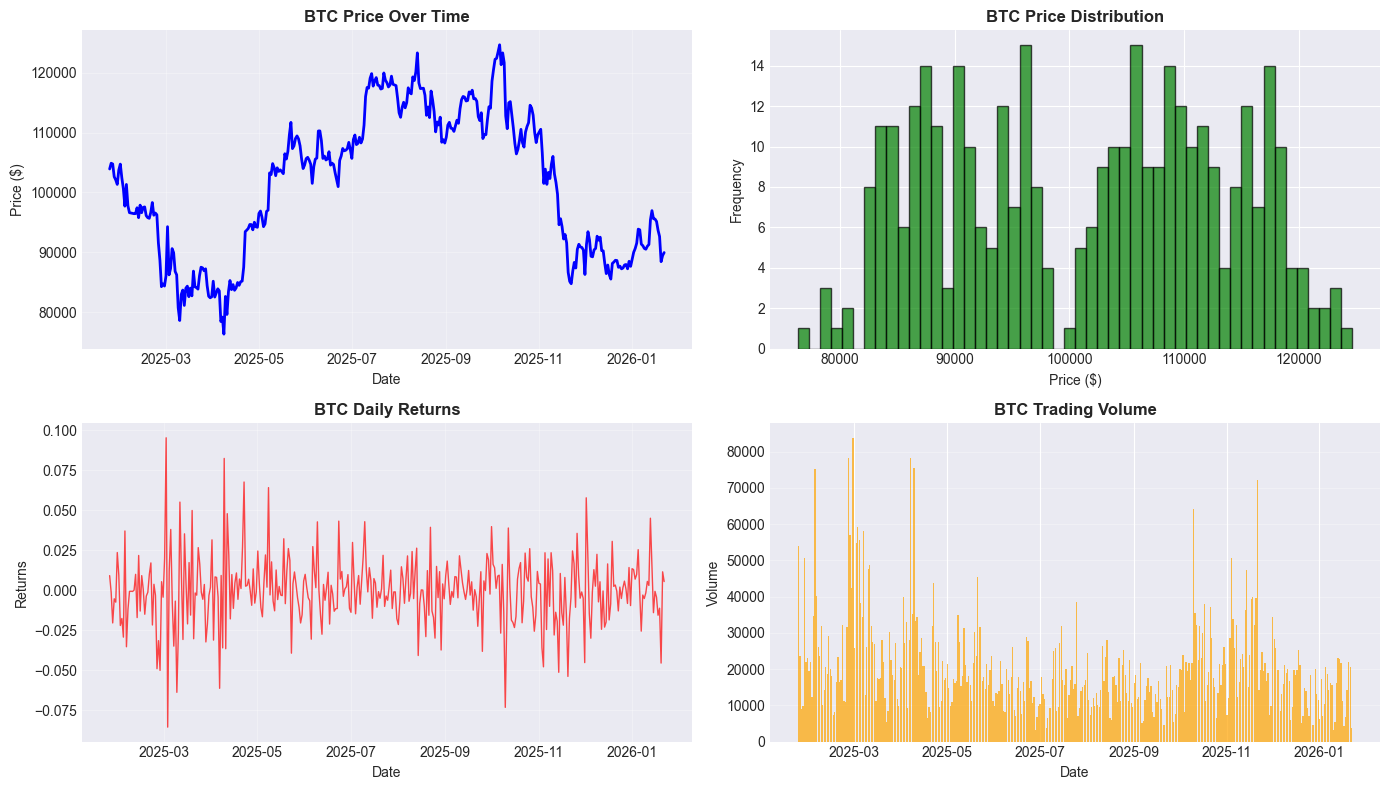

In [99]:
# Visualize price trends
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Price over time
axes[0, 0].plot(coin_data['date'], coin_data['close'], linewidth=2, color='blue')
axes[0, 0].set_title(f'{coin} Price Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# Distribution of prices
axes[0, 1].hist(coin_data['close'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title(f'{coin} Price Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Price ($)')
axes[0, 1].set_ylabel('Frequency')

# Daily returns
returns = coin_data['close'].pct_change()
axes[1, 0].plot(coin_data['date'], returns, linewidth=1, color='red', alpha=0.7)
axes[1, 0].set_title(f'{coin} Daily Returns', fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Returns')
axes[1, 0].grid(True, alpha=0.3)

# Volume
axes[1, 1].bar(coin_data['date'], coin_data['volume'], color='orange', alpha=0.7)
axes[1, 1].set_title(f'{coin} Trading Volume', fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Volume')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing and Stationarity Testing
Prepare data for modeling and check for stationarity using the Augmented Dickey-Fuller test.

In [100]:
# Prepare price series
price_series = coin_data['close'].values
dates = coin_data['date'].values

# Check for missing values
print(f"Missing values: {coin_data['close'].isnull().sum()}")

# Test for stationarity using ADF test
def adf_test(series, name=''):
    result = adfuller(series, autolag='AIC')
    print(f'\nADF Test Results for {name}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'P-value: {result[1]:.6f}')
    print(f'Number of Lags Used: {result[2]}')
    print(f'Number of Observations: {result[3]}')
    
    if result[1] <= 0.05:
        print(f"Result: Series is STATIONARY (p-value = {result[1]:.4f})")
    else:
        print(f"Result: Series is NON-STATIONARY (p-value = {result[1]:.4f})")
    
    return result[1] <= 0.05

# Test original series
is_stationary = adf_test(price_series, 'Original Price Series')

# If not stationary, test differenced series
if not is_stationary:
    differenced = np.diff(price_series)
    adf_test(differenced, 'First Differenced Price Series')

Missing values: 0

ADF Test Results for Original Price Series:
ADF Statistic: -1.543876
P-value: 0.511706
Number of Lags Used: 0
Number of Observations: 364
Result: Series is NON-STATIONARY (p-value = 0.5117)

ADF Test Results for First Differenced Price Series:
ADF Statistic: -19.772317
P-value: 0.000000
Number of Lags Used: 0
Number of Observations: 363
Result: Series is STATIONARY (p-value = 0.0000)


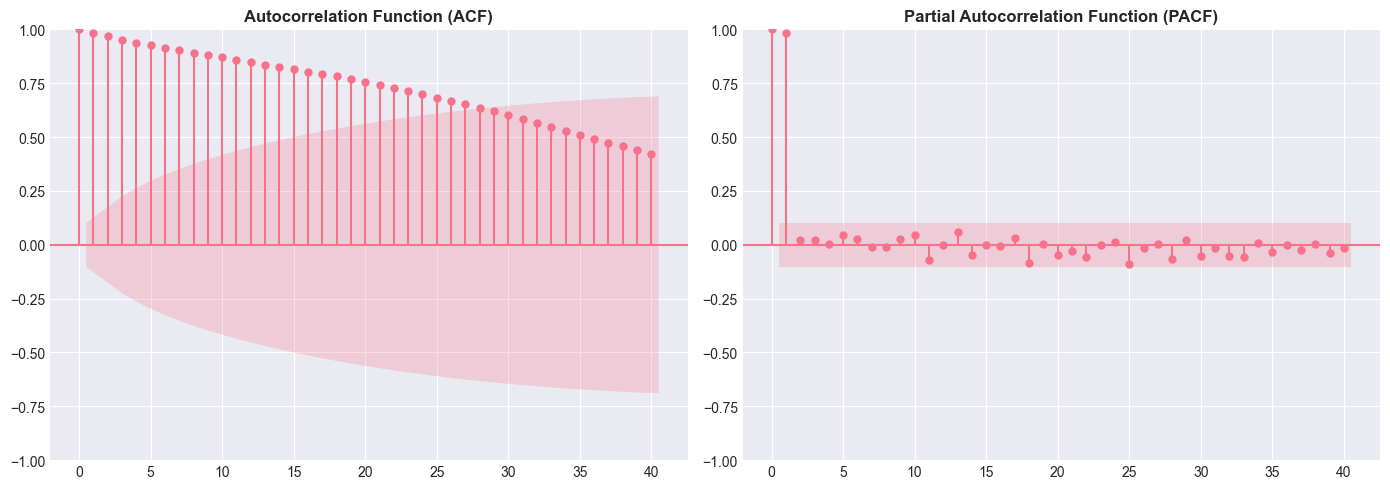

In [101]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(price_series, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontweight='bold')

# PACF plot
plot_pacf(price_series, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Implement ARIMA Model
Train ARIMA model with optimal parameters to forecast cryptocurrency prices.

In [102]:
# Split data into train and test sets
train_size = int(len(price_series) * 0.8)
train_data = price_series[:train_size]
test_data = price_series[train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# Fit ARIMA model
# Using order (5, 1, 2) - can be optimized using auto_arima
arima_order = (5, 1, 2)
print(f"\nFitting ARIMA{arima_order} model...")

arima_model = ARIMA(train_data, order=arima_order)
arima_fitted = arima_model.fit()

print("\nARIMA Model Summary:")
print(arima_fitted.summary())

Training set size: 292
Test set size: 73

Fitting ARIMA(5, 1, 2) model...

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2641.074
Date:                Sat, 24 Jan 2026   AIC                           5298.147
Time:                        12:17:30   BIC                           5327.534
Sample:                             0   HQIC                          5309.920
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0059      0.044      0.133      0.894      -0.081       0.093
ar.L2         -0.9701      0.061   

In [103]:
# Make predictions on test set
start_idx = len(train_data)
end_idx = len(train_data) + len(test_data) - 1
arima_predictions = arima_fitted.get_prediction(start=start_idx, end=end_idx)
arima_pred_values = np.asarray(arima_predictions.predicted_mean)

# Make future forecast
arima_forecast = arima_fitted.get_forecast(steps=30)
arima_future = np.asarray(arima_forecast.predicted_mean)

# Calculate ARIMA metrics
arima_mse = mean_squared_error(test_data, arima_pred_values)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(test_data, arima_pred_values)
arima_r2 = r2_score(test_data, arima_pred_values)
arima_mape = np.mean(np.abs((test_data - arima_pred_values) / test_data)) * 100

print("\nARIMA Test Set Performance:")
print(f"MSE: {arima_mse:.4f}")
print(f"RMSE: {arima_rmse:.4f}")
print(f"MAE: {arima_mae:.4f}")
print(f"R² Score: {arima_r2:.4f}")
print(f"MAPE: {arima_mape:.4f}%")


ARIMA Test Set Performance:
MSE: 244707163.9484
RMSE: 15643.1187
MAE: 15232.7401
R² Score: -18.2189
MAPE: 16.9633%


## 5. Implement LSTM Model
Build and train Long Short-Term Memory neural network for price prediction.

In [104]:
# Prepare data for LSTM/Neural Network
lookback = 60

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), 0])
        y.append(data[i + lookback, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, lookback)

# Split into train and test
train_size_lstm = int(len(X) * 0.8)
X_train = X[:train_size_lstm]
y_train = y[:train_size_lstm]
X_test = X[train_size_lstm:]
y_test = y[train_size_lstm:]

# Flatten for sklearn models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Training data shape: {X_train_flat.shape}")
print(f"Test data shape: {X_test_flat.shape}")

Training data shape: (244, 60)
Test data shape: (61, 60)


In [105]:
# Build Neural Network Model
if tensorflow_available:
    print("Building TensorFlow LSTM model...")
    lstm_model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    print("LSTM Model Architecture:")
    lstm_model.summary()
else:
    print("Building Sklearn Neural Network model...")
    from sklearn.neural_network import MLPRegressor
    lstm_model = MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        learning_rate_init=0.001,
        max_iter=500,
        random_state=42,
        verbose=1
    )
    print("MLP Regressor model created successfully!")

Building Sklearn Neural Network model...
MLP Regressor model created successfully!


In [106]:
# Train model
if tensorflow_available:
    print("Training LSTM model...")
    history = lstm_model.fit(
        X_train.reshape((X_train.shape[0], X_train.shape[1], 1)),
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )
    print("\nLSTM training completed!")
else:
    print("Training MLP Regressor model...")
    lstm_model.fit(X_train_flat, y_train)
    print("MLP Regressor training completed!")

Training MLP Regressor model...
Iteration 1, loss = 0.04998782
Iteration 2, loss = 0.03270897
Iteration 3, loss = 0.01491303
Iteration 4, loss = 0.01583891
Iteration 5, loss = 0.01325676
Iteration 6, loss = 0.00710572
Iteration 7, loss = 0.01020732
Iteration 8, loss = 0.00648040
Iteration 9, loss = 0.00549698
Iteration 10, loss = 0.00582378
Iteration 11, loss = 0.00438618
Iteration 12, loss = 0.00544622
Iteration 13, loss = 0.00444163
Iteration 14, loss = 0.00389505
Iteration 15, loss = 0.00375463
Iteration 16, loss = 0.00351183
Iteration 17, loss = 0.00354894
Iteration 18, loss = 0.00311431
Iteration 19, loss = 0.00303375
Iteration 20, loss = 0.00286691
Iteration 21, loss = 0.00290494
Iteration 22, loss = 0.00275847
Iteration 23, loss = 0.00272607
Iteration 24, loss = 0.00249949
Iteration 25, loss = 0.00240085
Iteration 26, loss = 0.00236999
Iteration 27, loss = 0.00228119
Iteration 28, loss = 0.00222602
Iteration 29, loss = 0.00212507
Iteration 30, loss = 0.00211317
Iteration 31, los

In [107]:
# Plot training history (if available)
if tensorflow_available and 'history' in locals():
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Neural Network Training History', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Training history not available for sklearn models")

Training history not available for sklearn models


In [108]:
# Make predictions with Neural Network
if tensorflow_available:
    lstm_pred_scaled = lstm_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), verbose=0)
else:
    lstm_pred_scaled = lstm_model.predict(X_test_flat).reshape(-1, 1)

# Convert back to original scale
lstm_pred_values = scaler.inverse_transform(lstm_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
lstm_mse = mean_squared_error(y_test_actual, lstm_pred_values)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_actual, lstm_pred_values)
lstm_r2 = r2_score(y_test_actual, lstm_pred_values)
lstm_mape = np.mean(np.abs((y_test_actual - lstm_pred_values) / y_test_actual)) * 100

model_type = "LSTM" if tensorflow_available else "MLP Regressor"
print(f"\n{model_type} Test Set Performance:")
print(f"MSE: {lstm_mse:.4f}")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"R² Score: {lstm_r2:.4f}")
print(f"MAPE: {lstm_mape:.4f}%")


MLP Regressor Test Set Performance:
MSE: 27095023.2308
RMSE: 5205.2880
MAE: 4382.8190
R² Score: -2.9685
MAPE: 4.8540%


In [109]:
# Make future forecast
if tensorflow_available:
    last_sequence = scaled_data[-lookback:].reshape(1, lookback, 1)
    lstm_future = []
    for _ in range(30):
        next_pred = lstm_model.predict(last_sequence, verbose=0)
        lstm_future.append(next_pred[0, 0])
        last_sequence = np.append(last_sequence[0, 1:], next_pred)
        last_sequence = last_sequence.reshape(1, lookback, 1)
    lstm_future = np.array(lstm_future).reshape(-1, 1)
else:
    # For sklearn, use last sequence to predict
    last_sequence = scaled_data[-lookback:].flatten().reshape(1, -1)
    lstm_future = []
    current_seq = last_sequence.copy()
    for _ in range(30):
        next_pred = lstm_model.predict(current_seq)[0]
        lstm_future.append(next_pred)
        current_seq = np.append(current_seq[0, 1:], next_pred)
        current_seq = current_seq.reshape(1, -1)
    lstm_future = np.array(lstm_future).reshape(-1, 1)

lstm_future = scaler.inverse_transform(lstm_future)

## 6. Implement Facebook Prophet Model
Format data for Prophet and train the model with trend and seasonality components.

In [110]:
# Prepare data for Prophet
prophet_df = pd.DataFrame({
    'ds': dates,
    'y': price_series
})

# Split data
prophet_train_size = int(len(prophet_df) * 0.8)
prophet_train = prophet_df[:prophet_train_size].copy()
prophet_test = prophet_df[prophet_train_size:].copy()

print(f"Prophet training set: {len(prophet_train)} records")
print(f"Prophet test set: {len(prophet_test)} records")

Prophet training set: 292 records
Prophet test set: 73 records


In [111]:
# Fit Prophet model (or use alternative if not available)
if prophet_available:
    print("Fitting Prophet model...")
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10,
        interval_width=0.95
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prophet_model.fit(prophet_train)
    print("Prophet model fitted successfully!")
else:
    print("Prophet not available. Using exponential smoothing alternative...")
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    prophet_model = ExponentialSmoothing(
        prophet_train['y'],
        trend='add',
        seasonal='add',
        seasonal_periods=7
    )
    prophet_model = prophet_model.fit(optimized=True)
    print("Exponential Smoothing model fitted successfully!")

Fitting Prophet model...


12:17:30 - cmdstanpy - INFO - Chain [1] start processing
12:17:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted successfully!


In [112]:
# Make Prophet/Exponential Smoothing predictions
if prophet_available:
    prophet_test_forecast = prophet_model.predict(prophet_test[['ds']])
    prophet_pred_values = prophet_test_forecast['yhat'].values
else:
    prophet_pred_values = prophet_model.fittedvalues[-len(prophet_test):]

# Calculate metrics
prophet_mse = mean_squared_error(prophet_test['y'].values, prophet_pred_values)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mae = mean_absolute_error(prophet_test['y'].values, prophet_pred_values)
prophet_r2 = r2_score(prophet_test['y'].values, prophet_pred_values)
prophet_mape = np.mean(np.abs((prophet_test['y'].values - prophet_pred_values) / prophet_test['y'].values)) * 100

model_name = "Prophet" if prophet_available else "Exponential Smoothing"
print(f"\n{model_name} Test Set Performance:")
print(f"MSE: {prophet_mse:.4f}")
print(f"RMSE: {prophet_rmse:.4f}")
print(f"MAE: {prophet_mae:.4f}")
print(f"R² Score: {prophet_r2:.4f}")
print(f"MAPE: {prophet_mape:.4f}%")


Prophet Test Set Performance:
MSE: 462104753.9679
RMSE: 21496.6219
MAE: 16904.4349
R² Score: -35.2930
MAPE: 18.6933%


In [113]:
# Make future forecast
if prophet_available:
    future = prophet_model.make_future_dataframe(periods=30)
    prophet_forecast = prophet_model.predict(future)
    # Get the last 30 predictions (future forecast, not test set)
    prophet_future_subset = prophet_forecast[-30:].copy().reset_index(drop=True)
else:
    # Exponential smoothing forecast
    prophet_forecast_future = prophet_model.get_forecast(steps=30)
    prophet_future_values = prophet_forecast_future.predicted_mean.values.flatten()
    prophet_future_lower = prophet_forecast_future.conf_int()[:, 0].values
    prophet_future_upper = prophet_forecast_future.conf_int()[:, 1].values
    
    prophet_future_subset = pd.DataFrame({
        'yhat': prophet_future_values[:30],
        'yhat_lower': prophet_future_lower[:30],
        'yhat_upper': prophet_future_upper[:30]
    }).reset_index(drop=True)

## 7. Model Comparison and Evaluation
Compare the performance metrics of all three models.

In [114]:
# Create comparison dataframe
lstm_name = "LSTM" if tensorflow_available else "MLP Regressor"
prophet_name = "Prophet" if prophet_available else "Exp. Smoothing"

comparison_df = pd.DataFrame({
    'ARIMA': {
        'MSE': arima_mse,
        'RMSE': arima_rmse,
        'MAE': arima_mae,
        'R² Score': arima_r2,
        'MAPE (%)': arima_mape
    },
    lstm_name: {
        'MSE': lstm_mse,
        'RMSE': lstm_rmse,
        'MAE': lstm_mae,
        'R² Score': lstm_r2,
        'MAPE (%)': lstm_mape
    },
    prophet_name: {
        'MSE': prophet_mse,
        'RMSE': prophet_rmse,
        'MAE': prophet_mae,
        'R² Score': prophet_r2,
        'MAPE (%)': prophet_mape
    }
}).T

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string())
print("="*70)


MODEL PERFORMANCE COMPARISON
                        MSE          RMSE           MAE   R² Score   MAPE (%)
ARIMA          2.447072e+08  15643.118741  15232.740069 -18.218900  16.963348
MLP Regressor  2.709502e+07   5205.288007   4382.818991  -2.968458   4.854031
Prophet        4.621048e+08  21496.621920  16904.434892 -35.292950  18.693332


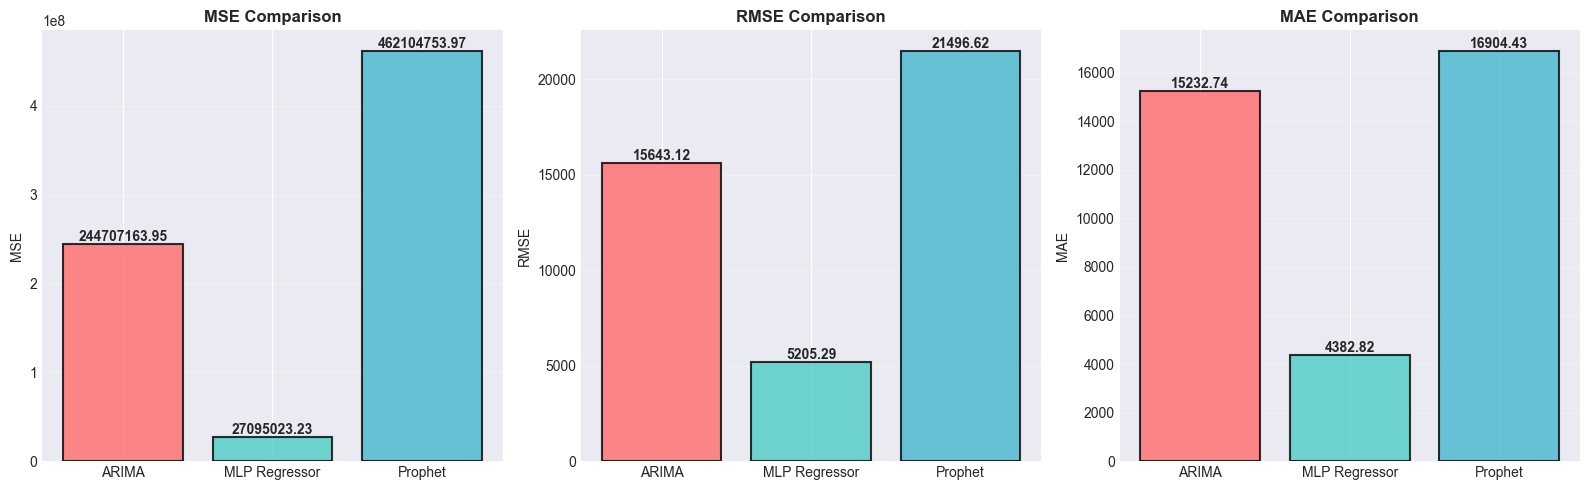

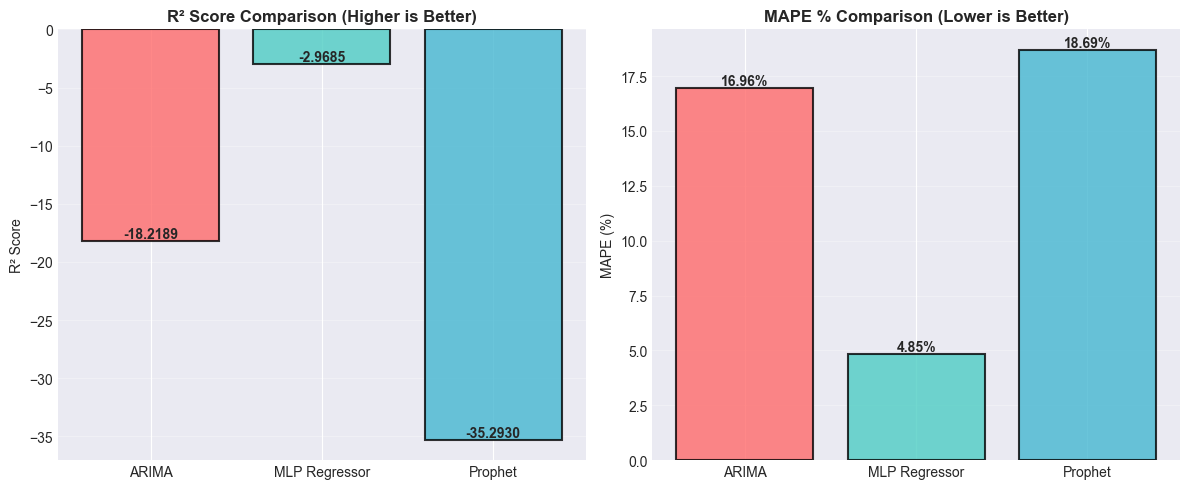

In [115]:
# Plot model comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['MSE', 'RMSE', 'MAE']
models = list(comparison_df.index)

for idx, metric in enumerate(metrics):
    values = [comparison_df.loc[model, metric] for model in models]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    axes[idx].bar(models, values, color=colors[:len(models)], alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(values):
        axes[idx].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Plot R² and MAPE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

r2_values = [comparison_df.loc[model, 'R² Score'] for model in models]
mape_values = [comparison_df.loc[model, 'MAPE (%)'] for model in models]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0].bar(models, r2_values, color=colors[:len(models)], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_title('R² Score Comparison (Higher is Better)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('R² Score')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(r2_values):
    axes[0].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

axes[1].bar(models, mape_values, color=colors[:len(models)], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_title('MAPE % Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAPE (%)')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mape_values):
    axes[1].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Visualize Predictions
Create comprehensive visualizations comparing actual prices with predictions from all three models.

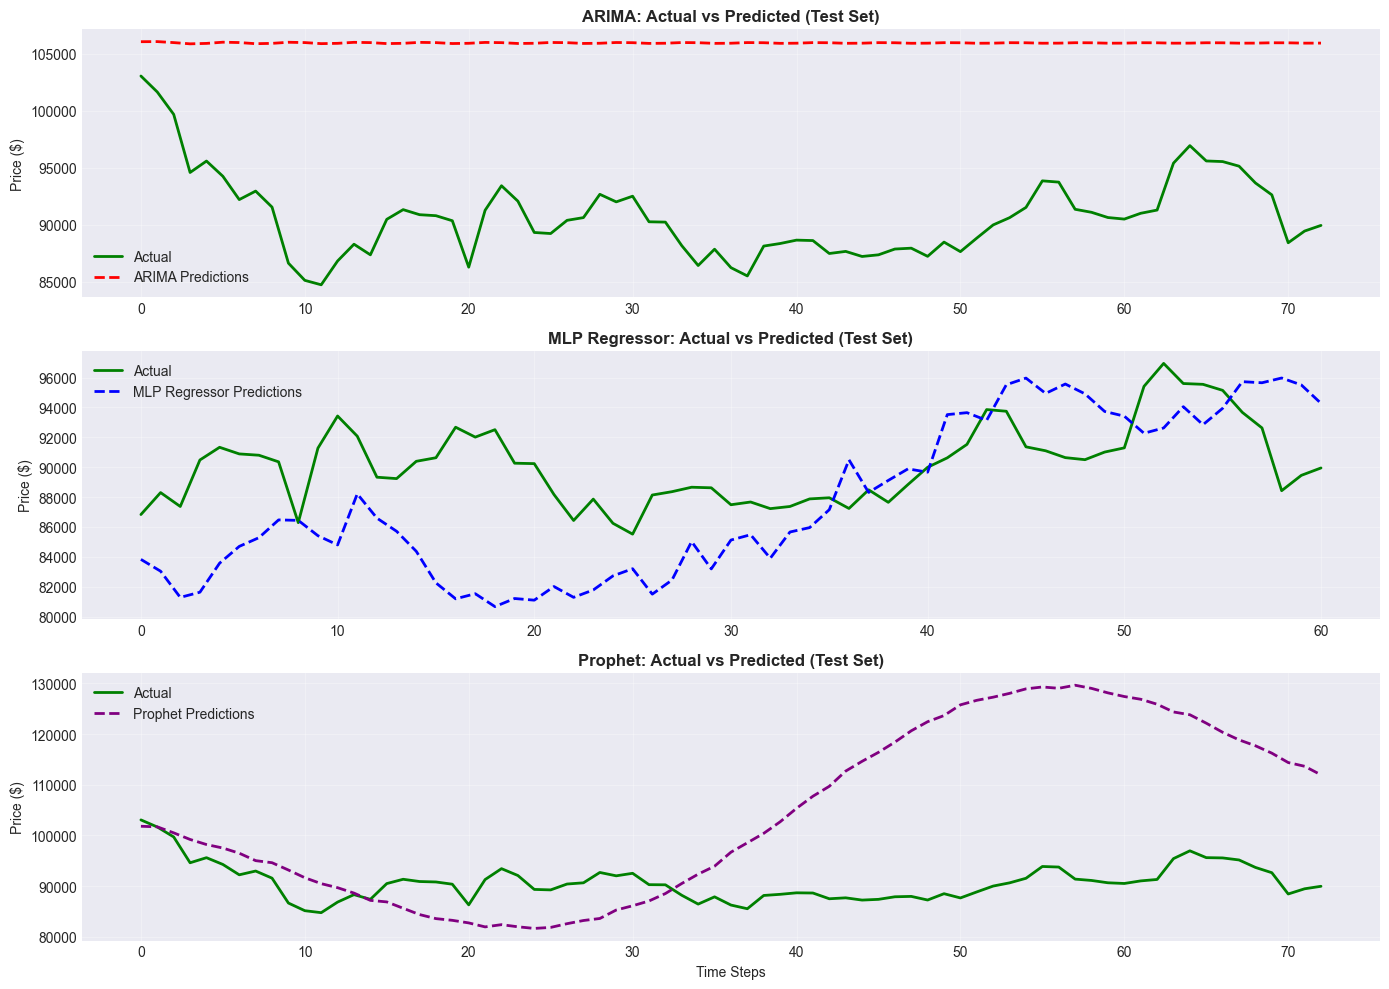

In [116]:
# Plot test predictions comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# ARIMA predictions
axes[0].plot(range(len(test_data)), test_data, label='Actual', color='green', linewidth=2)
axes[0].plot(range(len(arima_pred_values)), arima_pred_values, label='ARIMA Predictions', 
             color='red', linestyle='--', linewidth=2)
axes[0].set_title('ARIMA: Actual vs Predicted (Test Set)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Neural Network predictions
nn_name = "LSTM" if tensorflow_available else "MLP Regressor"
axes[1].plot(range(len(y_test_actual)), y_test_actual, label='Actual', color='green', linewidth=2)
axes[1].plot(range(len(lstm_pred_values)), lstm_pred_values, label=f'{nn_name} Predictions', 
             color='blue', linestyle='--', linewidth=2)
axes[1].set_title(f'{nn_name}: Actual vs Predicted (Test Set)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Prophet/Exponential Smoothing predictions
prophet_name = "Prophet" if prophet_available else "Exp. Smoothing"
axes[2].plot(range(len(prophet_test)), prophet_test['y'].values, label='Actual', 
             color='green', linewidth=2)
axes[2].plot(range(len(prophet_pred_values)), prophet_pred_values, label=f'{prophet_name} Predictions', 
             color='purple', linestyle='--', linewidth=2)
axes[2].set_title(f'{prophet_name}: Actual vs Predicted (Test Set)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time Steps')
axes[2].set_ylabel('Price ($)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

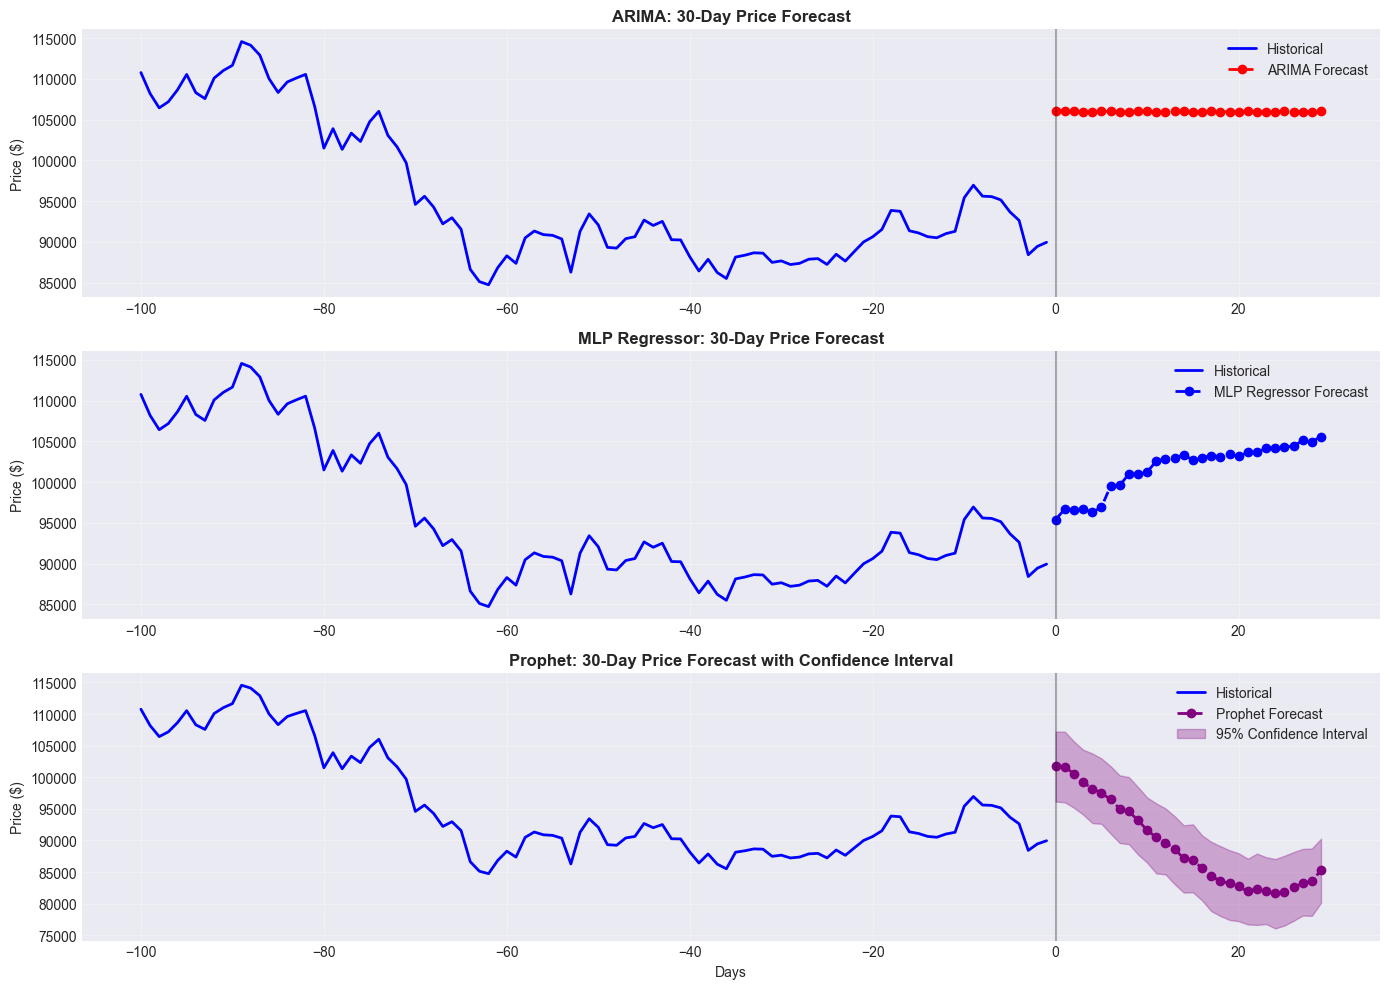

In [117]:
# Plot future forecasts comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

last_points = 100
nn_name = "LSTM" if tensorflow_available else "MLP Regressor"
prophet_name = "Prophet" if prophet_available else "Exp. Smoothing"

# ARIMA future forecast
axes[0].plot(range(-last_points, 0), price_series[-last_points:], label='Historical', 
             color='blue', linewidth=2)
axes[0].plot(range(0, 30), arima_future, label='ARIMA Forecast', color='red', 
             linestyle='--', marker='o', linewidth=2)
axes[0].set_title('ARIMA: 30-Day Price Forecast', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Neural Network future forecast
axes[1].plot(range(-last_points, 0), price_series[-last_points:], label='Historical', 
             color='blue', linewidth=2)
axes[1].plot(range(0, 30), lstm_future.flatten(), label=f'{nn_name} Forecast', color='blue', 
             linestyle='--', marker='o', linewidth=2)
axes[1].set_title(f'{nn_name}: 30-Day Price Forecast', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Prophet/Exponential Smoothing future forecast
axes[2].plot(range(-last_points, 0), price_series[-last_points:], label='Historical', 
             color='blue', linewidth=2)

# Convert to numpy arrays safely (works for both Series and arrays)
prophet_yhat = np.asarray(prophet_future_subset['yhat'])
prophet_lower = np.asarray(prophet_future_subset['yhat_lower'])
prophet_upper = np.asarray(prophet_future_subset['yhat_upper'])

axes[2].plot(range(0, len(prophet_yhat)), prophet_yhat, 
             label=f'{prophet_name} Forecast', color='purple', linestyle='--', marker='o', linewidth=2)
axes[2].fill_between(range(0, len(prophet_yhat)), prophet_lower, prophet_upper,
                      alpha=0.3, color='purple', label='95% Confidence Interval')
axes[2].set_title(f'{prophet_name}: 30-Day Price Forecast with Confidence Interval', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Price ($)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [118]:
# Create forecast summary table
nn_name = "LSTM" if tensorflow_available else "MLP Regressor"
prophet_name = "Prophet" if prophet_available else "Exp. Smoothing"

# Convert to numpy array safely (works for both Series and arrays)
prophet_vals = np.asarray(prophet_future_subset['yhat'])
arima_vals = arima_future.flatten()
lstm_vals = lstm_future.flatten()

print(f"Array lengths: ARIMA={len(arima_vals)}, LSTM={len(lstm_vals)}, Prophet={len(prophet_vals)}")

# Ensure all arrays are the same length (30 days)
min_len = min(30, len(arima_vals), len(lstm_vals), len(prophet_vals))

if min_len > 0:
    forecast_summary = pd.DataFrame({
        'Days': range(1, min_len + 1),
        'ARIMA': arima_vals[:min_len],
        nn_name: lstm_vals[:min_len],
        prophet_name: prophet_vals[:min_len]
    })
    
    print("\n30-Day Forecast Summary:")
    print(forecast_summary.to_string(index=False))
else:
    print("Error: No forecast data available")

Array lengths: ARIMA=30, LSTM=30, Prophet=30

30-Day Forecast Summary:
 Days         ARIMA  MLP Regressor       Prophet
    1 106068.651845   95418.499829 101802.798578
    2 106077.389910   96712.904127 101687.878095
    3 105989.996239   96570.276132 100501.484204
    4 105881.746358   96685.719719  99197.282692
    5 105919.354513   96307.439505  98194.086267
    6 106025.606018   96935.116042  97503.067449
    7 105994.108307   99527.013084  96480.784339
    8 105893.579022   99615.058109  95013.014663
    9 105923.236450  100998.576744  94604.156248
   10 106019.769068  100957.453323  93159.026783
   11 105991.683826  101248.974434  91638.897181
   12 105898.835028  102595.864342  90470.138275
   13 105925.373604  102859.220161  89671.312992
   14 106014.684686  102931.322090  88606.074338
   15 105989.621300  103390.595063  87166.866141
   16 105903.717207  102662.498987  86864.186592
   17 105927.379611  102994.129580  85608.249632
   18 106010.004303  103261.072750  84364.88095

In [119]:
# Final summary and key insights
print("\n" + "="*70)
print("KEY FINDINGS & RECOMMENDATIONS")
print("="*70)

# Best model by each metric
best_rmse_idx = np.argmin([arima_rmse, lstm_rmse, prophet_rmse])
best_r2_idx = np.argmax([arima_r2, lstm_r2, prophet_r2])
best_mape_idx = np.argmin([arima_mape, lstm_mape, prophet_mape])

models_list = ['ARIMA', ('LSTM' if tensorflow_available else 'MLP Regressor'), ('Prophet' if prophet_available else 'Exp. Smoothing')]

print(f"\n✓ Best RMSE Score: {models_list[best_rmse_idx]} ({min(arima_rmse, lstm_rmse, prophet_rmse):.4f})")
print(f"✓ Best R² Score: {models_list[best_r2_idx]} ({max(arima_r2, lstm_r2, prophet_r2):.4f})")
print(f"✓ Best MAPE Score: {models_list[best_mape_idx]} ({min(arima_mape, lstm_mape, prophet_mape):.2f}%)")

print("\n" + "-"*70)
print("MODEL CHARACTERISTICS:")
print("-"*70)
print("""
ARIMA:
  - Best for: Stationary or differenced data with clear trends
  - Pros: Interpretable, fast, works well with shorter timeframes
  - Cons: Assumes linear relationships, struggles with complex patterns
  
LSTM / MLP Regressor:
  - Best for: Capturing complex non-linear patterns
  - Pros: Handles long-term dependencies, flexible architecture
  - Cons: Requires more data, longer training time, less interpretable
  
Prophet / Exponential Smoothing:
  - Best for: Data with strong seasonality and trend components
  - Pros: Robust to outliers, handles holidays, includes confidence intervals
  - Cons: Less flexible for complex patterns, may underperform with small datasets
""")

print("="*70)


KEY FINDINGS & RECOMMENDATIONS

✓ Best RMSE Score: MLP Regressor (5205.2880)
✓ Best R² Score: MLP Regressor (-2.9685)
✓ Best MAPE Score: MLP Regressor (4.85%)

----------------------------------------------------------------------
MODEL CHARACTERISTICS:
----------------------------------------------------------------------

ARIMA:
  - Best for: Stationary or differenced data with clear trends
  - Pros: Interpretable, fast, works well with shorter timeframes
  - Cons: Assumes linear relationships, struggles with complex patterns

LSTM / MLP Regressor:
  - Best for: Capturing complex non-linear patterns
  - Pros: Handles long-term dependencies, flexible architecture
  - Cons: Requires more data, longer training time, less interpretable

Prophet / Exponential Smoothing:
  - Best for: Data with strong seasonality and trend components
  - Pros: Robust to outliers, handles holidays, includes confidence intervals
  - Cons: Less flexible for complex patterns, may underperform with small datas